## 분류

In [1]:
# 라이블러리 불러오기
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [135]:
data=pd.read_csv("C:/Users/samsung-user/OneDrive/바탕 화면/인공지능개론/7주차/BP_data.csv")

In [50]:
data.head()

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,1,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0


In [182]:
data.isnull().sum()

Patient_Number                      0
Blood_Pressure_Abnormality          0
Level_of_Hemoglobin                 0
Genetic_Pedigree_Coefficient        0
Age                                 0
BMI                                 0
Sex                                 0
Pregnancy                        1558
Smoking                             0
Physical_activity                   0
salt_content_in_the_diet            0
alcohol_consumption_per_day         0
Level_of_Stress                     0
Chronic_kidney_disease              0
Adrenal_and_thyroid_disorders       0
dtype: int64

In [187]:
# 1) Genetic_Pedigree_Coefficient -> 평균 대체
data['Genetic_Pedigree_Coefficient'] = data['Genetic_Pedigree_Coefficient'].fillna(data['Genetic_Pedigree_Coefficient'].mean())
# 2) Pregnancy -> 삭제
data['Pregnancy'] = data['Pregnancy'].fillna(0)
# 3) alcohol_consumption_per_day -> 평균 대체
data['alcohol_consumption_per_day'] = data['alcohol_consumption_per_day'].fillna(data['alcohol_consumption_per_day'].mean())

In [188]:
data['Blood_Pressure_Abnormality'] = data['Blood_Pressure_Abnormality'].astype(float)

In [189]:
# 데이터 /타겟 분리
X = data.drop('Blood_Pressure_Abnormality', axis=1).values
y = data['Blood_Pressure_Abnormality'].values

In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Patient_Number                 2000 non-null   int64  
 1   Blood_Pressure_Abnormality     2000 non-null   float64
 2   Level_of_Hemoglobin            2000 non-null   float64
 3   Genetic_Pedigree_Coefficient   2000 non-null   float64
 4   Age                            2000 non-null   int64  
 5   BMI                            2000 non-null   int64  
 6   Sex                            2000 non-null   int64  
 7   Pregnancy                      2000 non-null   float64
 8   Smoking                        2000 non-null   int64  
 9   Physical_activity              2000 non-null   int64  
 10  salt_content_in_the_diet       2000 non-null   int64  
 11  alcohol_consumption_per_day    2000 non-null   float64
 12  Level_of_Stress                2000 non-null   i

In [191]:
# 표준화
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [192]:
# 훈련/테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((1600, 14), (400, 14), (1600,), (400,))

In [193]:
# 파이토치 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [194]:
# DataLoader 생성
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [195]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1600, 14]),
 torch.Size([400, 14]),
 torch.Size([1600, 1]),
 torch.Size([400, 1]))

In [196]:
class BPDense(nn.Module):
    def __init__(self):
        super(BPDense, self).__init__()
        self.fc1 = nn.Linear(14, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [197]:
model = BPDense()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [198]:
train_losses = []
test_accuracies = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_dataloader))

    # 평가
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/20, Loss: 0.6720, Accuracy: 67.75%
Epoch 2/20, Loss: 0.5840, Accuracy: 71.25%
Epoch 3/20, Loss: 0.5157, Accuracy: 70.00%
Epoch 4/20, Loss: 0.4867, Accuracy: 70.25%
Epoch 5/20, Loss: 0.4599, Accuracy: 73.75%
Epoch 6/20, Loss: 0.4286, Accuracy: 74.75%
Epoch 7/20, Loss: 0.3951, Accuracy: 78.25%
Epoch 8/20, Loss: 0.3612, Accuracy: 80.50%
Epoch 9/20, Loss: 0.3349, Accuracy: 80.75%
Epoch 10/20, Loss: 0.3136, Accuracy: 81.25%
Epoch 11/20, Loss: 0.2988, Accuracy: 83.50%
Epoch 12/20, Loss: 0.2882, Accuracy: 82.25%
Epoch 13/20, Loss: 0.2825, Accuracy: 83.00%
Epoch 14/20, Loss: 0.2736, Accuracy: 83.25%
Epoch 15/20, Loss: 0.2620, Accuracy: 83.75%
Epoch 16/20, Loss: 0.2616, Accuracy: 84.50%
Epoch 17/20, Loss: 0.2552, Accuracy: 84.00%
Epoch 18/20, Loss: 0.2486, Accuracy: 83.25%
Epoch 19/20, Loss: 0.2436, Accuracy: 84.25%
Epoch 20/20, Loss: 0.2386, Accuracy: 85.00%


In [199]:
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).int().view(-1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='binary')
precision = precision_score(all_labels, all_predictions, average='binary')
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate specificity (1 - false positive rate)
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0.0)

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[167  38]
 [ 22 173]]
F1 Score: 0.85
Precision: 0.82
Recall: 0.89
Specificity: 0.85


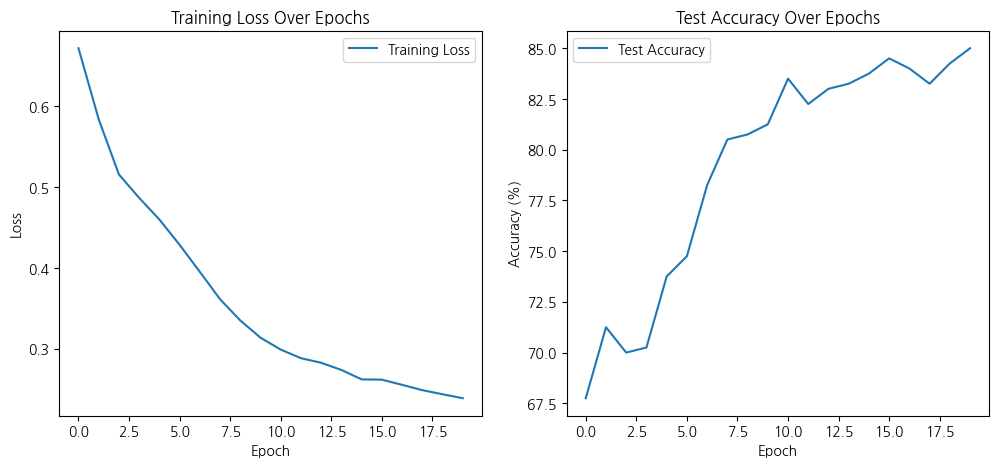

In [200]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()
plt.show()

## EDA

In [129]:
data.head()

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1.0,11.28,0.90,34,23,1,1.0,0,45961,48071,260.643068,2,1,1
6,7,1.0,11.69,0.75,43,41,1,1.0,0,38369,32967,206.000000,3,1,1
15,16,1.0,10.96,0.10,43,27,1,1.0,0,7329,39018,495.000000,1,1,0
18,19,1.0,8.99,0.17,18,30,1,1.0,0,43934,35603,260.643068,3,1,0
24,25,0.0,10.26,0.69,23,48,1,1.0,1,4861,25482,260.643068,3,1,0


### 결측치 처리

In [136]:
# 결측치 확인
data.isnull().sum()

Patient_Number                      0
Blood_Pressure_Abnormality          0
Level_of_Hemoglobin                 0
Genetic_Pedigree_Coefficient       92
Age                                 0
BMI                                 0
Sex                                 0
Pregnancy                        1558
Smoking                             0
Physical_activity                   0
salt_content_in_the_diet            0
alcohol_consumption_per_day       242
Level_of_Stress                     0
Chronic_kidney_disease              0
Adrenal_and_thyroid_disorders       0
dtype: int64

In [137]:
# 1) Genetic_Pedigree_Coefficient -> 평균 대체
data['Genetic_Pedigree_Coefficient'] = data['Genetic_Pedigree_Coefficient'].fillna(data['Genetic_Pedigree_Coefficient'].mean())
# 2) Pregnancy -> 삭제
data['Pregnancy'] = data['Pregnancy'].fillna(0)
# 3) alcohol_consumption_per_day -> 평균 대체
data['alcohol_consumption_per_day'] = data['alcohol_consumption_per_day'].fillna(data['alcohol_consumption_per_day'].mean())

In [138]:
data.head()

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,251.008532,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.000000,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.000000,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.000000,1,1,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.000000,2,0,0


In [139]:
data.isnull().sum()

Patient_Number                      0
Blood_Pressure_Abnormality          0
Level_of_Hemoglobin                 0
Genetic_Pedigree_Coefficient        0
Age                                 0
BMI                                 0
Sex                                 0
Pregnancy                        1558
Smoking                             0
Physical_activity                   0
salt_content_in_the_diet            0
alcohol_consumption_per_day         0
Level_of_Stress                     0
Chronic_kidney_disease              0
Adrenal_and_thyroid_disorders       0
dtype: int64

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

### 시각화

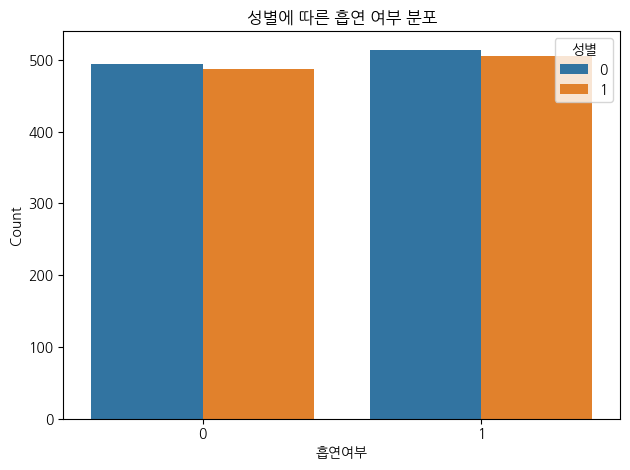

In [201]:
# 1) 카운트플롯 시각화
# 성별, 흡연유무
sns.countplot(data=data, x='Smoking', hue='Sex')

plt.title('성별에 따른 흡연 여부 분포')
plt.xlabel('흡연여부')
plt.ylabel('Count')
plt.legend(title='성별')
plt.tight_layout()
plt.show()

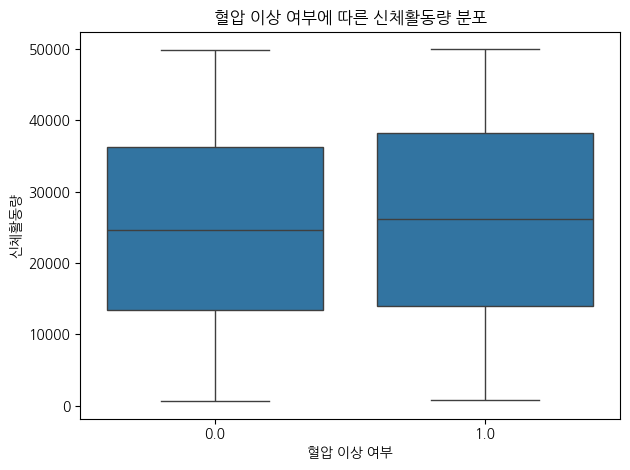

In [202]:
# 2) 박스플롯 시각화
# 혈압, 신체활동
sns.boxplot(data=data, x='Blood_Pressure_Abnormality', y='Physical_activity')

plt.title('혈압 이상 여부에 따른 신체활동량 분포')
plt.xlabel('혈압 이상 여부')
plt.ylabel('신체활동량')
plt.tight_layout()
plt.show()

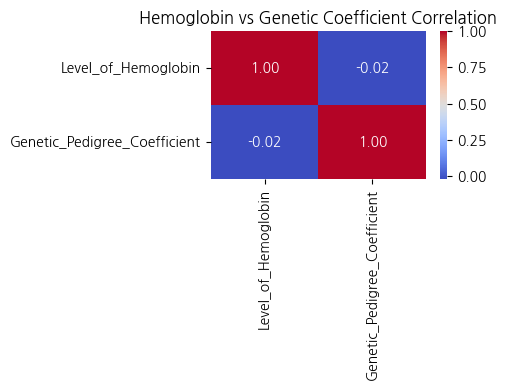

In [203]:
# 3) 히트맵 시각화
# Level_of_Hemoglobin - Genetic_Pedigree_Coefficient
cols = ['Level_of_Hemoglobin', 'Genetic_Pedigree_Coefficient']
corr = data[cols].corr()

# 히트맵 그리기
plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Hemoglobin vs Genetic Coefficient Correlation')
plt.tight_layout()
plt.show()

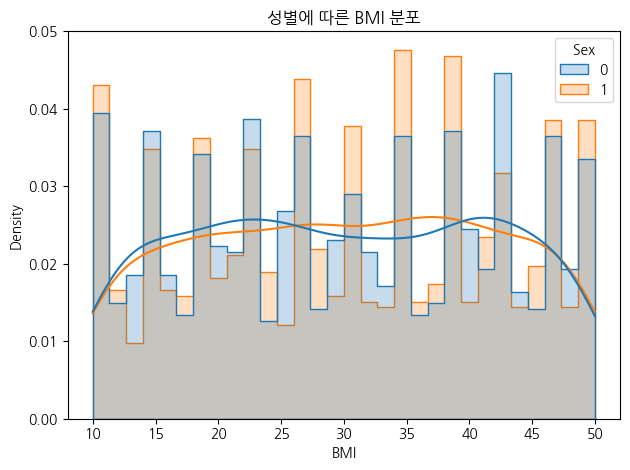

In [204]:
# 4) 히스토그램 시각화
# 성별, BMI
sns.histplot(data=data, x='BMI', hue='Sex', kde=True, bins=30, element="step", stat="density", common_norm=False)
plt.title('성별에 따른 BMI 분포')
plt.xlabel('BMI')
plt.tight_layout()
plt.show()

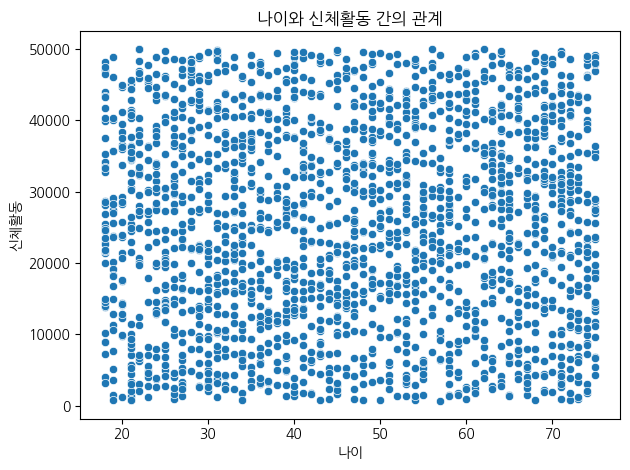

In [205]:
# 5) 산점도 시각화
# 나이, BMI
sns.scatterplot(data=data, x='Age', y='Physical_activity')

plt.title('나이와 신체활동 간의 관계')
plt.xlabel('나이')
plt.ylabel('신체활동')
plt.tight_layout()
plt.show()